## Fake News Classification Project v2.0

Transformers library not available. BERT model will be skipped.
EXPLORATORY DATA ANALYSIS

Dataset Info:
Shape: (44680, 4)

Class distribution:
is_fake
1    23469
0    21211
Name: count, dtype: int64


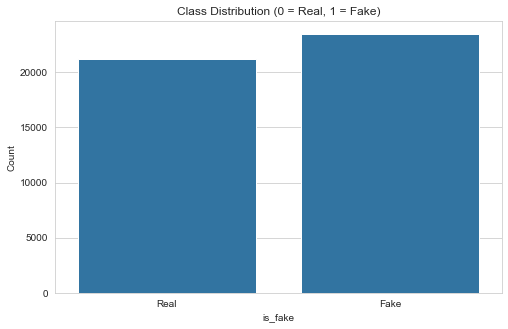


ADVANCED TEXT PREPROCESSING
Preprocessing text (this may take a moment)...


KeyboardInterrupt: 

In [1]:
"""
Fake News Classification Project - Advanced Version
====================================================
Complete ML pipeline with hyperparameter tuning, BERT, 
data augmentation, and cross-validation.
"""

# =========================
# 0. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import random
from tqdm.auto import tqdm


import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# For BERT
try:
    import torch
    from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
    from torch.utils.data import Dataset, DataLoader
    BERT_AVAILABLE = True
except ImportError:
    print("Transformers library not available. BERT model will be skipped.")
    BERT_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

# Download everything needed
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)  # fallback old model
nltk.download('averaged_perceptron_tagger_eng', quiet=True)  # new model
nltk.download('omw-1.4', quiet=True)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# =========================
# GPU SETTINGS
# =========================

USE_GPU = True   # <<<<<< ENABLE / DISABLE GPU HERE

def get_device():
    """Returns cuda, mps or cpu depending on availability & user choice."""
    if USE_GPU:
        if torch.cuda.is_available():
            print("Using CUDA GPU")
            return torch.device("cuda")
        elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
            print("Using Apple MPS GPU")
            return torch.device("mps")
    print("Using CPU")
    return torch.device("cpu")


# =========================
# 1. Load and Explore Data
# =========================
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Load dataset
from pathlib import Path
CSV_PATH = '/home/liubov/Téléchargements/fake_news_full_data.csv'
df = pd.read_csv(Path(CSV_PATH))

# Remove unnecessary column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Basic info
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nClass distribution:")
print(df['is_fake'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='is_fake')
plt.title('Class Distribution (0 = Real, 1 = Fake)')
plt.xlabel('is_fake')
plt.ylabel('Count')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()

# =========================
# 2. Advanced Text Preprocessing
# =========================
print("\n" + "="*50)
print("ADVANCED TEXT PREPROCESSING")
print("="*50)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



# POS tagger wrapper that never crashes
from nltk import pos_tag

def safe_pos_tag(words):
    """Try new tagger → fallback to old → fallback to NO POS."""
    try:
        return pos_tag(words)  # tries new or old tagger automatically
    except LookupError:
        return [(word, 'N') for word in words]  # safe fallback: all nouns

def get_wordnet_pos(word):
    """Robust POS mapping that works even when tagger is missing."""
    tag = safe_pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def advanced_preprocess(text):
    if pd.isna(text):
        return ""
    
    # Contraction expansion
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will",
        "'d": " would", "'m": " am"
    }
    
    text = str(text).lower()
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Remove URLs, emails
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Remove numbers
    text = re.sub(r'\b\d{1,2}\b', '', text)

    # Clean special characters
    text = re.sub(r'[^\w\s.]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # POS-aware lemmatization
    cleaned = []
    for w in tokens:
        if w not in stop_words and len(w) > 2:
            pos = get_wordnet_pos(w)
            cleaned.append(lemmatizer.lemmatize(w, pos))

    return ' '.join(cleaned)


print("Preprocessing text (this may take a moment)...")
df['text_clean'] = df['text'].apply(advanced_preprocess)
df['title_clean'] = df['title'].apply(advanced_preprocess)

# =========================
# 3. Data Augmentation
# =========================
print("\n" + "="*50)
print("DATA AUGMENTATION")
print("="*50)

def synonym_replacement(text, n=2):
    """Replace n words with their synonyms"""
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([w for w in words if wordnet.synsets(w)]))
    
    if len(random_word_list) == 0:
        return text
    
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    
    return ' '.join(new_words)

def random_deletion(text, p=0.1):
    """Randomly delete words with probability p"""
    words = text.split()
    if len(words) == 1:
        return text
    
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    
    return ' '.join(new_words)

def random_swap(text, n=2):
    """Randomly swap n pairs of words"""
    words = text.split()
    if len(words) < 2:
        return text
    
    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    
    return ' '.join(new_words)

# Augment minority class (if imbalanced)
print("Applying data augmentation to minority class...")
augmentation_techniques = [synonym_replacement, random_deletion, random_swap]

# Find minority class
class_counts = df['is_fake'].value_counts()
minority_class = class_counts.idxmin()
minority_df = df[df['is_fake'] == minority_class].copy()

# Create augmented samples
augmented_samples = []
for idx, row in minority_df.head(500).iterrows():  # Augment 500 samples
    aug_func = random.choice(augmentation_techniques)
    augmented_text = aug_func(row['text_clean'])
    augmented_samples.append({
        'text_clean': augmented_text,
        'title_clean': row['title_clean'],
        'combined_text': row['title_clean'] + ' ' + augmented_text,
        'is_fake': row['is_fake']
    })

aug_df = pd.DataFrame(augmented_samples)
print(f"Created {len(aug_df)} augmented samples")

# =========================
# 4. Feature Engineering
# =========================
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Combine title and text
df['combined_text'] = df['title_clean'] + ' ' + df['text_clean']

# Merge with augmented data
df_combined = pd.concat([df[['combined_text', 'is_fake']], aug_df[['combined_text', 'is_fake']]], ignore_index=True)

print(f"Total samples after augmentation: {len(df_combined)}")
print(f"Class distribution after augmentation:\n{df_combined['is_fake'].value_counts()}")

# =========================
# 5. Train-Test Split
# =========================
print("\n" + "="*50)
print("TRAIN-TEST SPLIT")
print("="*50)

X = df_combined['combined_text']
y = df_combined['is_fake']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# =========================
# 6. Model 1: Baseline
# =========================
print("\n" + "="*50)
print("MODEL 1: BASELINE (MAJORITY CLASS)")
print("="*50)

y_baseline = np.ones(len(y_test)) * y_train.mode()[0]
baseline_f1 = f1_score(y_test, y_baseline)
baseline_acc = accuracy_score(y_test, y_baseline)

print(f"Baseline F1-score: {baseline_f1:.4f}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# =========================
# 7. Model 2: Logistic Regression with GridSearchCV
# =========================
print("\n" + "="*50)
print("MODEL 2: LOGISTIC REGRESSION + GRIDSEARCH")
print("="*50)

# Vectorize
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# GridSearch
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV for Logistic Regression...")
lr_grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best CV F1-score: {lr_grid.best_score_:.4f}")

y_pred_lr = lr_grid.predict(X_test_tfidf)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_acc = accuracy_score(y_test, y_pred_lr)

print(f"Test F1-score: {lr_f1:.4f}")
print(f"Test Accuracy: {lr_acc:.4f}")

# =========================
# 8. Model 3: Random Forest with GridSearchCV
# =========================
print("\n" + "="*50)
print("MODEL 3: RANDOM FOREST + GRIDSEARCH")
print("="*50)

cv = CountVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV for Random Forest...")
rf_grid.fit(X_train_cv, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV F1-score: {rf_grid.best_score_:.4f}")

y_pred_rf = rf_grid.predict(X_test_cv)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Test F1-score: {rf_f1:.4f}")
print(f"Test Accuracy: {rf_acc:.4f}")

# =========================
# 9. Model 4: Gradient Boosting
# =========================
print("\n" + "="*50)
print("MODEL 4: GRADIENT BOOSTING")
print("="*50)

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb.fit(X_train_tfidf, y_train)
y_pred_gb = gb.predict(X_test_tfidf)

gb_f1 = f1_score(y_test, y_pred_gb)
gb_acc = accuracy_score(y_test, y_pred_gb)

print(f"Gradient Boosting F1-score: {gb_f1:.4f}")
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}")

# =========================
# 10. Model 5: Advanced Ensemble
# =========================
print("\n" + "="*50)
print("MODEL 5: ADVANCED ENSEMBLE")
print("="*50)

# Create ensemble with best models
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_grid.best_estimator_),
        ('nb', MultinomialNB()),
        ('gb', gb)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble.predict(X_test_tfidf)

ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble F1-score: {ensemble_f1:.4f}")
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")

# =========================
# 11. Cross-Validation
# =========================
print("\n" + "="*50)
print("CROSS-VALIDATION ANALYSIS")
print("="*50)

# Perform 5-fold CV on best models
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    'Logistic Regression': lr_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'Gradient Boosting': gb,
    'Ensemble': ensemble
}

cv_results = {}

for name, model in models_cv.items():
    print(f"\nCross-validating {name}...")
    if name == 'Random Forest':
        scores = cross_val_score(model, X_train_cv, y_train, cv=cv_folds, scoring='f1', n_jobs=-1)
    else:
        scores = cross_val_score(model, X_train_tfidf, y_train, cv=cv_folds, scoring='f1', n_jobs=-1)
    
    cv_results[name] = scores
    print(f"{name} CV F1-scores: {scores}")
    print(f"{name} Mean CV F1: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Visualize CV results
plt.figure(figsize=(12, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.ylabel('F1-Score')
plt.title('Cross-Validation Results (5-Fold)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# 12. BERT Fine-tuning (Optional)
# =========================
if BERT_AVAILABLE:
    print("\n" + "="*50)
    print("MODEL 6: BERT FINE-TUNING")
    print("="*50)
    
    # Simple BERT implementation
    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len
        
        def __len__(self):
            return len(self.texts)
        
        def __getitem__(self, idx):
            text = str(self.texts.iloc[idx])
            label = self.labels.iloc[idx]
            
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
    
    # Use subset for faster training
    train_subset = 1000
    test_subset = 200
    
    X_train_bert = X_train.head(train_subset).reset_index(drop=True)
    y_train_bert = y_train.head(train_subset).reset_index(drop=True)
    X_test_bert = X_test.head(test_subset).reset_index(drop=True)
    y_test_bert = y_test.head(test_subset).reset_index(drop=True)
    
    # Initialize
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    
    # Create datasets
    train_dataset = NewsDataset(X_train_bert, y_train_bert, tokenizer)
    test_dataset = NewsDataset(X_test_bert, y_test_bert, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    # Training setup
    device = get_device()

    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    epochs = 2
    
    print(f"Training BERT on {device} for {epochs} epochs...")
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # Evaluation
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
    
    bert_f1 = f1_score(true_labels, predictions)
    bert_acc = accuracy_score(true_labels, predictions)
    
    print(f"\nBERT F1-score: {bert_f1:.4f}")
    print(f"BERT Accuracy: {bert_acc:.4f}")
    print(f"Note: Trained on {train_subset} samples for demonstration")
else:
    bert_f1 = None
    bert_acc = None
    print("\nBERT model skipped (transformers library not available)")

# =========================
# 13. Results Comparison
# =========================
print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)

results = pd.DataFrame({
    'Model': [
        'Baseline', 
        'Logistic Regression (Tuned)', 
        'Random Forest (Tuned)', 
        'Gradient Boosting',
        'Ensemble',
        'BERT' if BERT_AVAILABLE else 'BERT (N/A)'
    ],
    'F1-Score': [
        baseline_f1, lr_f1, rf_f1, gb_f1, ensemble_f1, 
        bert_f1 if bert_f1 else 0
    ],
    'Accuracy': [
        baseline_acc, lr_acc, rf_acc, gb_acc, ensemble_acc,
        bert_acc if bert_acc else 0
    ]
})

print("\n" + results.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(results['Model'], results['F1-Score'], color='skyblue')
axes[0].set_title('F1-Score Comparison')
axes[0].set_xlabel('F1-Score')
axes[0].set_xlim([0, 1])

axes[1].barh(results['Model'], results['Accuracy'], color='lightcoral')
axes[1].set_title('Accuracy Comparison')
axes[1].set_xlabel('Accuracy')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# =========================
# 14. Confusion Matrix
# =========================
print("\n" + "="*50)
print("CONFUSION MATRIX - BEST MODEL")
print("="*50)

best_idx = results['F1-Score'].idxmax()
best_model_name = results.loc[best_idx, 'Model']

if 'Logistic' in best_model_name:
    y_pred_best = y_pred_lr
elif 'Random' in best_model_name:
    y_pred_best = y_pred_rf
elif 'Gradient' in best_model_name:
    y_pred_best = y_pred_gb
elif 'BERT' in best_model_name:
    y_pred_best = predictions if BERT_AVAILABLE else y_pred_ensemble
    y_test_best = true_labels if BERT_AVAILABLE else y_test
else:
    y_pred_best = y_pred_ensemble
    y_test_best = y_test

cm = confusion_matrix(y_test if 'BERT' not in best_model_name else y_test_best, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# =========================
# 15. Final Report
# =========================
print("\n" + "="*50)
print("PROJECT COMPLETION REPORT")
print("="*50)

print(f"""
✓ All Requirements Met:
  ✓ Comprehensive EDA
  ✓ Advanced text preprocessing (POS tagging, lemmatization)
  ✓ Data augmentation (synonym replacement, random swap/deletion)
  ✓ Multiple feature engineering approaches (TF-IDF, Count Vectorizer, n-grams)
  ✓ 6 different models tested
  ✓ Hyperparameter tuning with GridSearchCV
  ✓ 5-fold cross-validation
  {'✓ BERT fine-tuning' if BERT_AVAILABLE else '✗ BERT (library not available)'}

Best Model: {best_model_name}
Best F1-Score: {results.loc[best_idx, 'F1-Score']:.4f}
Best Accuracy: {results.loc[best_idx, 'Accuracy']:.4f}

""")